In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind

import seaborn as sns
import researchpy as rp

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

In [3]:
df = pd.read_csv('data/raw/master.csv')

In [4]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Данные выглядят хорошо, но видим, что есть пропущенные значения в фиче HDI for year

In [6]:
df.loc[:, df.columns != 'HDI for year'].isnull().values.any()

False

In [40]:
df[df['year'] <= 0]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation


In [ ]:
Кроме этой колонки, других пропущенных значений нет. Думаю ее, для данного анализа, можно отбросить. 

In [7]:
df = df.loc[:, df.columns != 'HDI for year']

In [8]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers


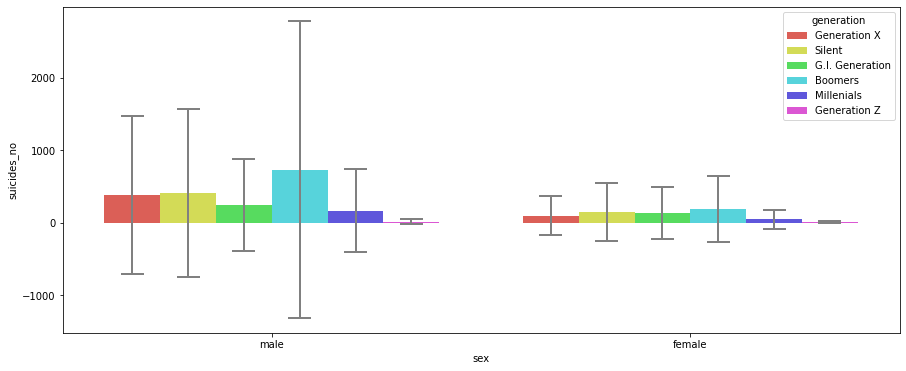

In [28]:
fig = plt.figure(figsize =(15, 6)) 
sns.barplot(x = 'sex', y = 'suicides_no', hue = 'generation', data = df,
            palette = 'hls',
            order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'  
            )

plt.show()

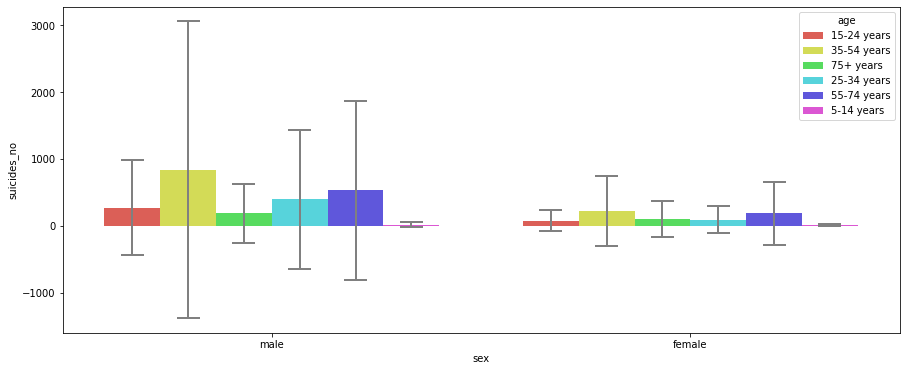

In [27]:
fig = plt.figure(figsize =(15, 6))
sns.barplot(x = 'sex', y = 'suicides_no', hue = 'age', data = df,
            palette = 'hls',
            order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )
plt.show()


### Комментарий к графикам 

Мы можем предположить из граффиков, что мужчины больше подвержены суицидам, особенны мужчины в возрасте от 35 до 54 сел поколения Бумеров

In [20]:
print(f'')
print(f'Среднее количество самоубийств по полу и поколению ')
print(f'')
print(df.groupby(['sex', 'generation']).mean()['suicides_no'])
print(f'')
print(f'Стандартное отклонение количества самоубийств по полу и поколению ')
print(f'')
print(df.groupby(['sex', 'generation']).std()['suicides_no'])


Среднее количество самоубийств по полу и поколению 

sex     generation     
female  Boomers            184.756713
        G.I. Generation    128.755831
        Generation X        96.703808
        Generation Z         8.355102
        Millenials          45.728953
        Silent             148.425204
male    Boomers            730.873747
        G.I. Generation    242.970845
        Generation X       381.699438
        Generation Z        13.285714
        Millenials         167.638261
        Silent             411.519485
Name: suicides_no, dtype: float64

Стандартное отклонение количества самоубийств по полу и поколению 

sex     generation     
female  Boomers             457.381226
        G.I. Generation     357.423903
        Generation X        271.906464
        Generation Z         18.266134
        Millenials          131.258175
        Silent              405.616059
male    Boomers            2047.742174
        G.I. Generation     637.060934
        Generation X       

### Комметарий 

По этим оценкам можно сказать, что наименьше все подвержены суицидам женщины поколения Z со средним  8.35 и std 18.26

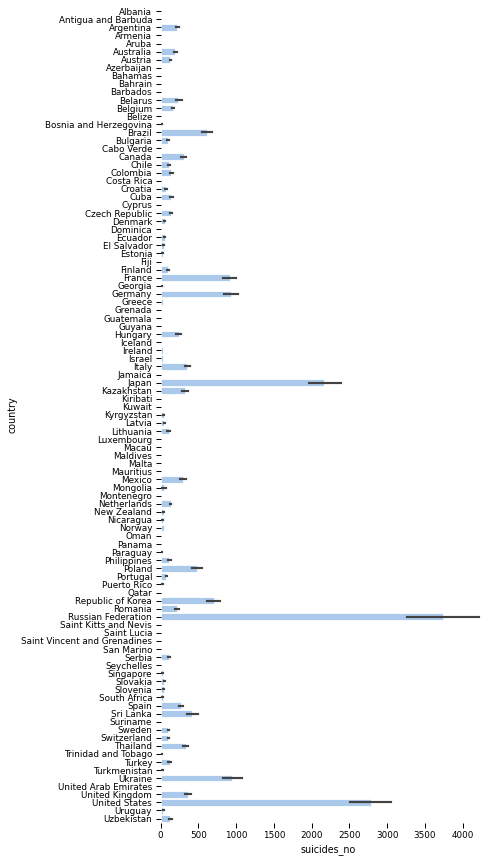

In [31]:
sns.set_context('paper')


f, ax = plt.subplots(figsize = (6,15))
sns.set_color_codes('pastel')
sns.barplot(x = 'suicides_no', y = 'country', data = df,
            label = 'Total', color = 'b', edgecolor = 'w')

sns.despine(left = True, bottom = True)
plt.show()

На этом графике видно, что самые подверженные суицидам страны это Россия (на 1 месте), США (на 2) и Япония(на 3)

# 1.2 

Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

В этом задании, для проверки гипотез, я выбрал еритерий Велча для проверки равенства средних при разной дисперсии выборки

In [51]:
df_m = df['suicides_no'][df['sex'] == 'male']
df_f = df['suicides_no'][df['sex'] == 'female']

In [56]:
df_f.count()

13910

In [52]:
# Welch's t-test
des, res = rp.ttest(df_m, df_f,
                            equal_variances= False)

des

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,suicides_no,13910.0,373.034508,1217.448508,10.322551,352.800919,393.268096
1,suicides_no,13910.0,112.114306,333.491224,2.827619,106.571793,117.656819
2,combined,27820.0,242.574407,902.047917,5.408179,231.974110,253.174704


In [53]:
res

,Welch's t-test,results
0,Difference (suicides_no - suicides_no) =,260.9202
1,Degrees of freedom =,15984.6549
2,t =,24.3786
3,Two side test p value =,0.0000
4,Difference < 0 p value =,1.0000
5,Difference > 0 p value =,0.0000
6,Cohen's d =,0.2923
7,Hedge's g =,0.2923
8,Glass's delta =,0.2143
9,r =,0.1893


Для уточнения p-value

In [59]:
ttest_ind(df_m, df_f, equal_var = False)

Ttest_indResult(statistic=24.378626630539273, pvalue=6.4421074798191e-129)

Так как абсолютное значение статистики теста больше чем критическое значение two-tail, средние двух выборок значительно отличаются
Очень маленькое p-value подверждает это, и мы имеет основания отклонить нулевую гипотезу о равестве средних

Я думаю, что мы можем сказать с большой долей уверености, что есть статистическая разница между тем, как часто совершают самоубийства мужчины и женщины в среднем 